# Water Treatment Plant - Exploring the Data

<br />
<br />
<br />

### Table of Contents

* Introduction to Waste Water Treatment Plants
* Introduction to Data Set

<br />
<br />
<br />

# Introduction to Waste Water Treatment Plants

While a toilet joke may be a more appropriate way to begin this discussion, let's start with where the toilet goes. When waste water is collected, it must be treated at a large facility that utilizes biological and chemical means to remove solids, chemicals, and other nasties. 



# Introduction

[Link to data set on Kaggle](https://archive.ics.uci.edu/ml/datasets/Water+Treatment+Plant)

In [3]:
# numerics
import numpy as np
import pandas as pd

# learn you some machines
from sklearn.preprocessing import StandardScaler

# viz
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns

# essentials
from pprint import pprint
import os, io, re
from datetime import datetime

In [4]:
os.listdir('data/water_treatment/')

['water-treatment.data', 'water-treatment.names']

In [5]:
# Read water treatment plant data into a dataframe
df = pd.read_csv('data/water_treatment/water-treatment.data',
                    na_values='?',
                    header=None)

# Load information about column codes and their descriptions
info = pd.read_csv('data/water_treatment/water-treatment.names',
                    engine='python',
                    skiprows=64, nrows=38, 
                    names = ['Code','Description'],
                    header=None, 
                    index_col=0,
                    na_values='?',
                    delimiter=r' {2,}')

In [6]:
#print help(pd.read_csv)

In [7]:
print df.head(5)
print info.head(5)

         0        1    2    3      4      5      6     7    8     9   ...    \
0  D-1/3/90  44101.0  1.5  7.8    NaN  407.0  166.0  66.3  4.5  2110  ...     
1  D-2/3/90  39024.0  3.0  7.7    NaN  443.0  214.0  69.2  6.5  2660  ...     
2  D-4/3/90  32229.0  5.0  7.6    NaN  528.0  186.0  69.9  3.4  1666  ...     
3  D-5/3/90  35023.0  3.5  7.9  205.0  588.0  192.0  65.6  4.5  2430  ...     
4  D-6/3/90  36924.0  1.5  8.0  242.0  496.0  176.0  64.8  4.0  2110  ...     

       29    30    31    32    33    34    35    36    37     38  
0  2000.0   NaN  58.8  95.5   NaN  70.0   NaN  79.4  87.3   99.6  
1  2590.0   NaN  60.7  94.8   NaN  80.8   NaN  79.5  92.1  100.0  
2  1888.0   NaN  58.2  95.6   NaN  52.9   NaN  75.8  88.7   98.5  
3  1840.0  33.1  64.2  95.3  87.3  72.3  90.2  82.3  89.6  100.0  
4  2120.0   NaN  62.7  95.6   NaN  71.0  92.1  78.2  87.5   99.5  

[5 rows x 39 columns]
    Code                                   Description
1    Q-E                         (input flow 

In [8]:
# Column labes are the codes, plus one more column for "Date"
column_labels = np.concatenate([np.array(['Date']), info['Code'].values])
df.columns = column_labels

# Parse the Date column from D-(day)/(month)/(yr) to datetime
df['Date'] = df['Date'].apply(lambda x : datetime.strptime(x,'D-%d/%m/%y'))

# Use the date as the index
df.set_index('Date')

print("")

In [9]:
info.index = info.index - 1
print info

        Code                                        Description
0        Q-E                              (input flow to plant)
1       ZN-E                              (input Zinc to plant)
2       PH-E                                (input pH to plant)
3      DBO-E       (input Biological demand of oxygen to plant)
4      DQO-E         (input chemical demand of oxygen to plant)
5       SS-E                  (input suspended solids to plant)
6      SSV-E          (input volatile supended solids to plant)
7      SED-E                         (input sediments to plant)
8     COND-E                      (input conductivity to plant)
9       PH-P                      (input pH to primary settler)
10     DBO-P  (input Biological demand of oxygen to primary ...
11      SS-P        (input suspended solids to primary settler)
12     SSV-P  (input volatile supended solids to primary set...
13     SED-P               (input sediments to primary settler)
14    COND-P            (input conductiv

In [10]:
print("Total time covered by data set:")
print(df.loc[df.shape[0]-1,'Date'] - df.loc[0,'Date'])

Total time covered by data set:
547 days 00:00:00


In [11]:
inputs      = info[  info['Description'].apply(lambda x : '(input' in x)  ]

plant_inputs      = info[  info['Description'].apply(lambda x : '(input' in x and 'plant' in x)  ]
tank1_inputs      = info[  info['Description'].apply(lambda x : '(input' in x and 'primary settler' in x)  ]
tank2_inputs      = info[  info['Description'].apply(lambda x : '(input' in x and 'secondary settler' in x)  ]

perf_inputs = info[  info['Description'].apply(lambda x : '(performance input' in x)  ]
glob_inputs = info[  info['Description'].apply(lambda x : '(global performance input' in x)  ]

outputs     = info[  info['Description'].apply(lambda x : '(output' in x)   ]

# Process Inputs

Let's start by examining the input variables to the process. We have a few different types of measurements of input variables, measured at three locations in the process - once at the input to the plant, once at the input to the primary settling tank, and once at the input to the secondary settling tank. We're ultimately interested in analyzing the operation of this chemical plant, and classifying operational states, with the aim of predicting faults using the state variables at each stage.

## Visualizing Time Series

To visualize the entire time series, we just pick an input variable to visualize:

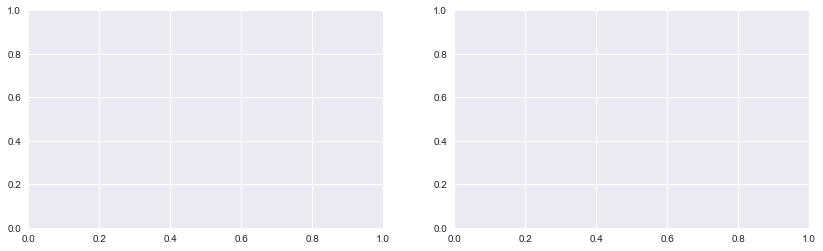

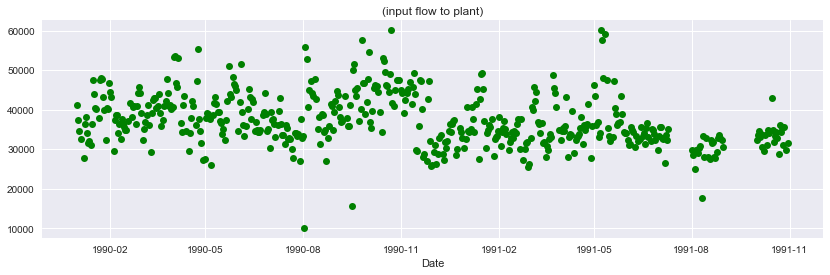

In [12]:
fig = figure(figsize=(14,4))
ax = fig.add_subplot(111)

which_input = 0
which_label = inputs.loc[which_input,'Code']
which_descr = inputs.loc[which_input,'Description']

xx = df['Date']
yy = df[which_label]

# Plot 
ax.plot( xx, yy, 'go' )

# Annotate
ax.set_title(which_descr)

ax.set_xlabel('Date')

plt.show()

In [13]:
def plot_ts_in(inlabels,n):
    """
    Plot a time series of water treatment plant data.
    
    inputs - list of input labels
    n = which input label to use
    """
    fig = figure(figsize=(14,4))
    ax = fig.add_subplot(111)

    which_input = n
    which_label = inlabels.loc[which_input,'Code']
    which_descr = inlabels.loc[which_input,'Description']

    xx = df['Date']
    yy = df[which_label]

    # Plot 
    ax.plot( xx, yy, 'go' )

    # Annotate
    ax.set_title(which_descr)

    ax.set_xlabel('Date')

    plt.show()
    
print("")

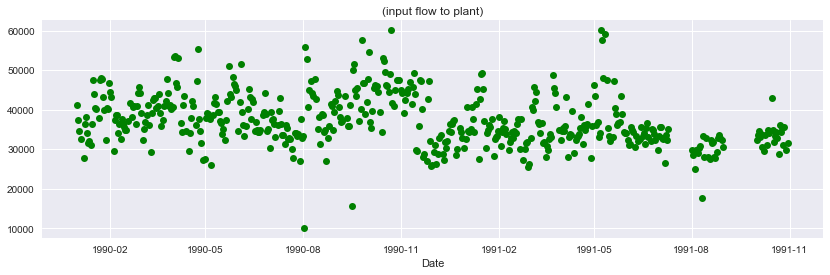

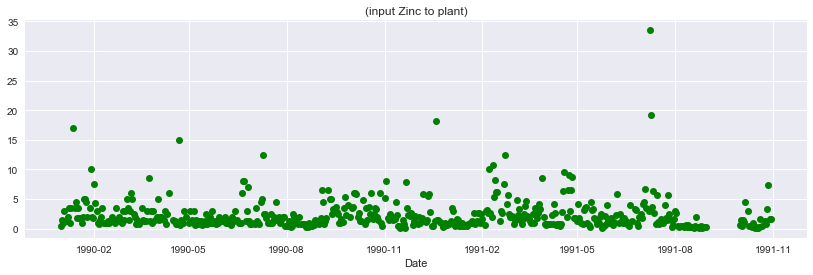

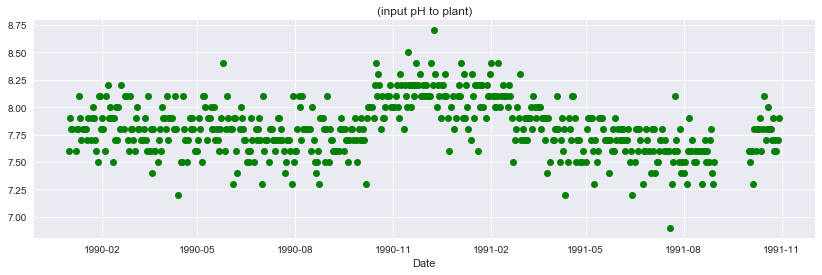

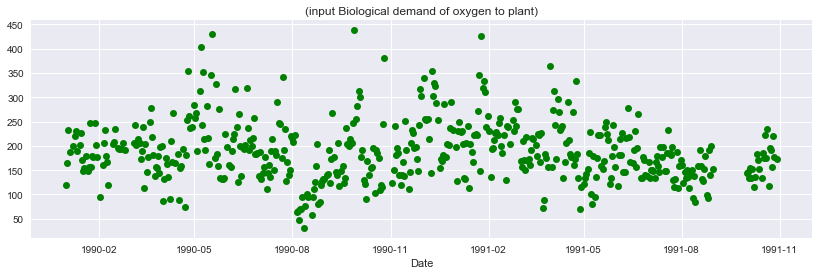

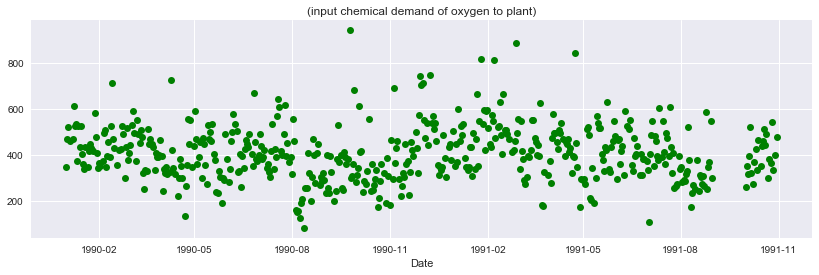

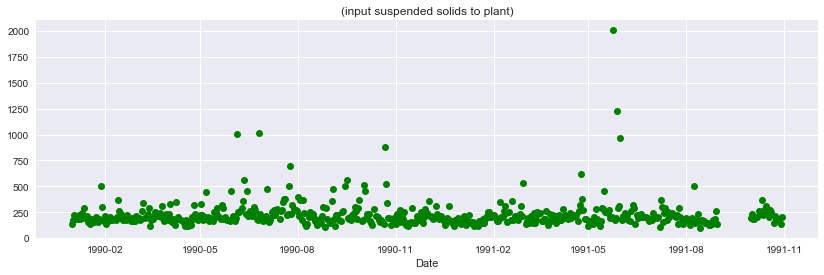

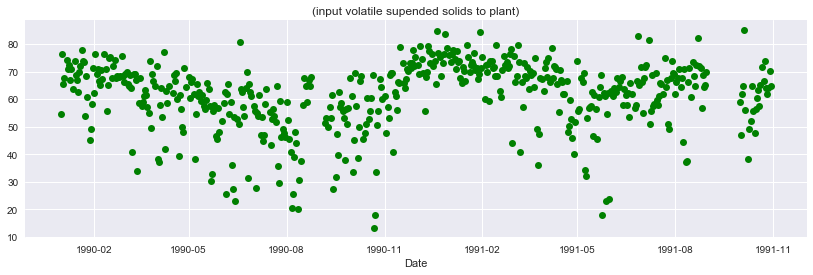

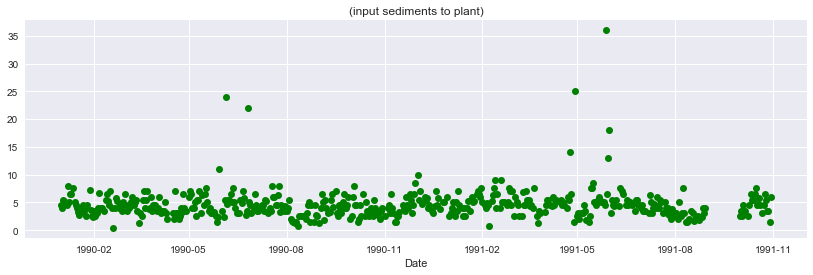

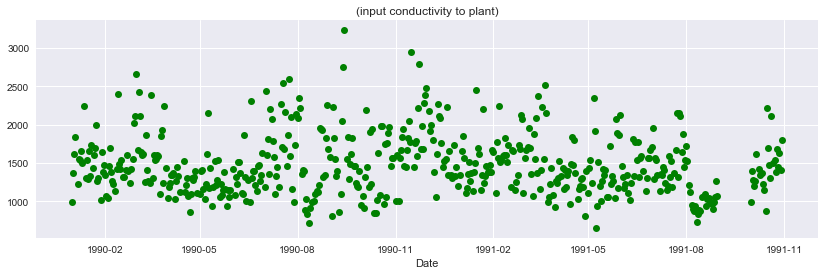

In [14]:
for i in range(len(plant_inputs)):
    plot_ts_in(plant_inputs,i)

There are more time series to explore and compare:

In [15]:
# To color each point by the digit it represents,
# create a color map with 10 elements (10 RGB values).
# Then, use the system response (y_training), which conveniently
# is a digit from 0 to 9.
def get_cmap(n):
    #colorz = plt.cm.cool
    colorz = plt.get_cmap('Set1')
    return [ colorz(float(i)/n) for i in range(n)]

In [16]:
print info

        Code                                        Description
0        Q-E                              (input flow to plant)
1       ZN-E                              (input Zinc to plant)
2       PH-E                                (input pH to plant)
3      DBO-E       (input Biological demand of oxygen to plant)
4      DQO-E         (input chemical demand of oxygen to plant)
5       SS-E                  (input suspended solids to plant)
6      SSV-E          (input volatile supended solids to plant)
7      SED-E                         (input sediments to plant)
8     COND-E                      (input conductivity to plant)
9       PH-P                      (input pH to primary settler)
10     DBO-P  (input Biological demand of oxygen to primary ...
11      SS-P        (input suspended solids to primary settler)
12     SSV-P  (input volatile supended solids to primary set...
13     SED-P               (input sediments to primary settler)
14    COND-P            (input conductiv

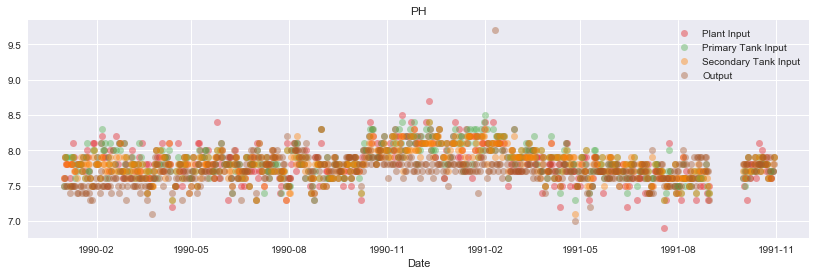

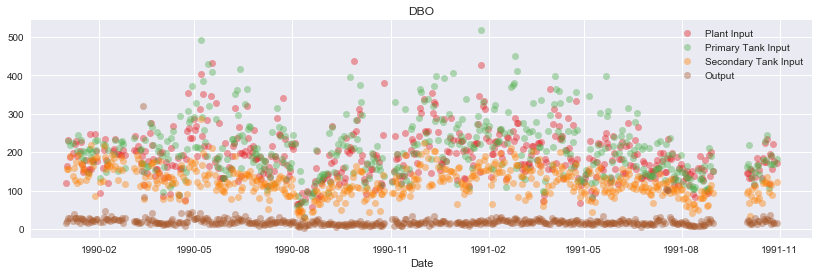

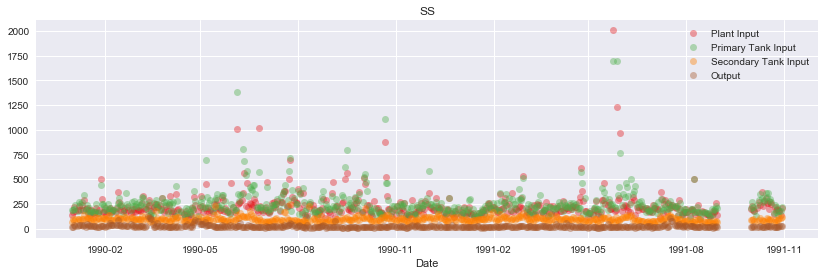

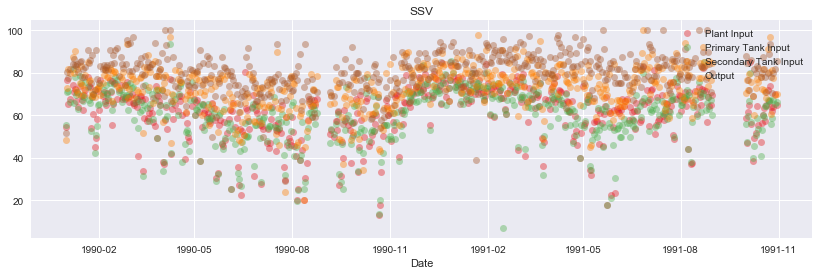

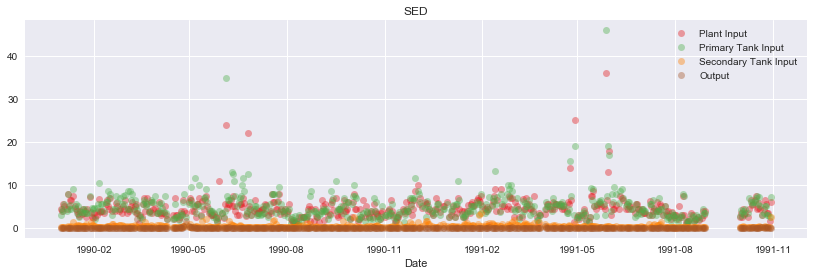

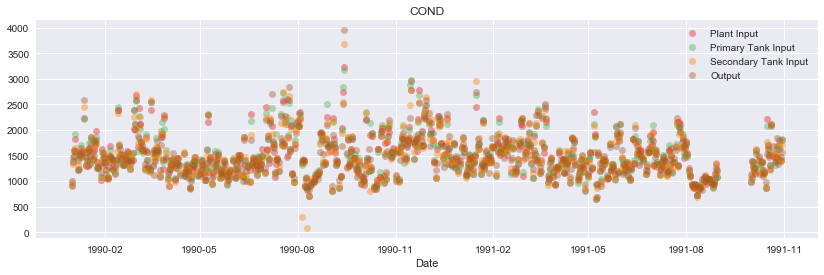

In [17]:
#print inputs
label_prefixes = ['PH','DBO','SS','SSV','SED','COND']
label_suffixes = ['-E','-P','-D','-S']
label_legend = ['Plant Input','Primary Tank Input','Secondary Tank Input','Output']

# color by label suffix (plant input, primary input, secondary input)
colorz = get_cmap(len(label_suffixes))

for label_prefix in label_prefixes:

    fig = figure(figsize=(14,4))
    ax = fig.add_subplot(111)

    xx = df['Date']
    
    for j,label_suffix in enumerate(label_suffixes):
        
        this_label = label_prefix + label_suffix
        yy = df[this_label]    

        # Plot 
        ax.plot( xx, yy, 'o', color=colorz[j], alpha=0.4, label=label_legend[j])

    # Annotate
    ax.set_title(label_prefix)

    ax.set_xlabel('Date')

    plt.legend(loc='upper right')
    plt.show()

# Histograms

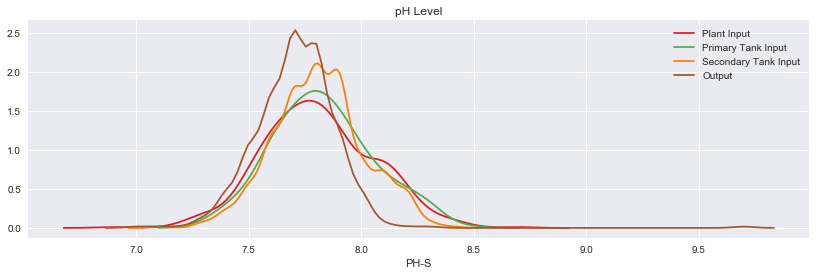

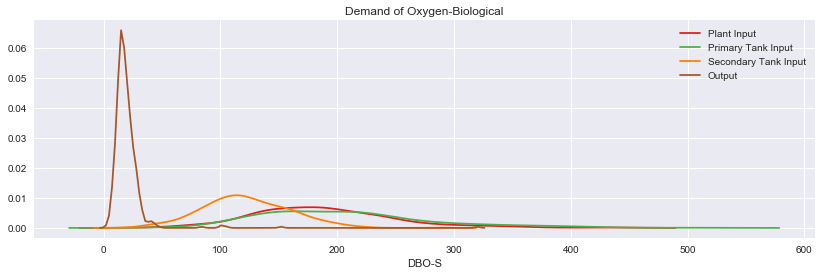

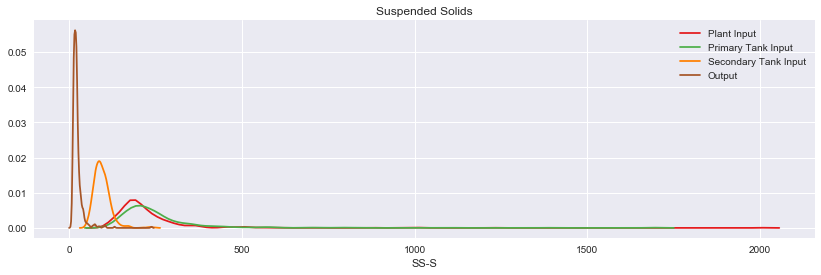

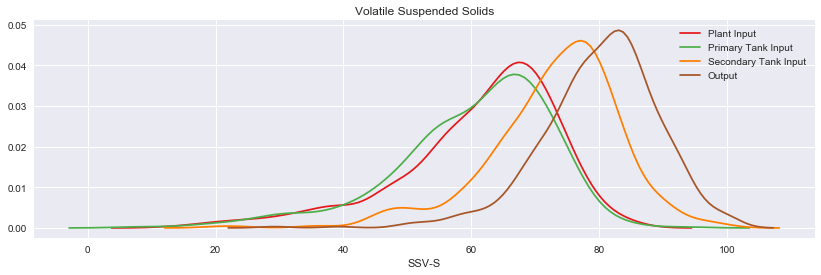

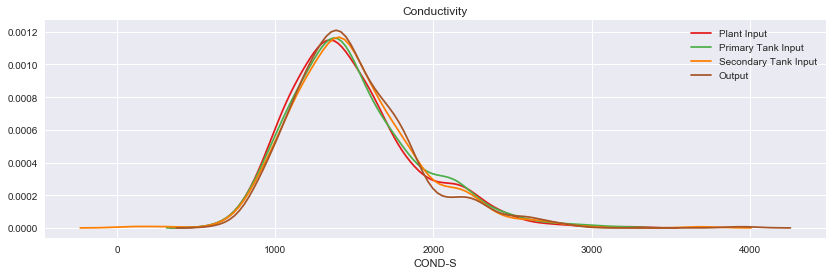

In [18]:
label_prefixes = ['PH','DBO','SS','SSV','COND']
titles = ['pH Level','Demand of Oxygen-Biological',
          'Suspended Solids','Volatile Suspended Solids',
          'Conductivity']

label_suffixes = ['-E','-P','-D','-S']
label_legend = ['Plant Input','Primary Tank Input','Secondary Tank Input','Output']

# color by label suffix (plant input, primary input, secondary input)
def get_cmap(n):
    #colorz = plt.cm.cool
    colorz = plt.get_cmap('Set1')
    return [ colorz(float(i)/n) for i in range(n)]
colorz = get_cmap(len(label_suffixes))

for i,label_prefix in enumerate(label_prefixes):

    fig = figure(figsize=(14,4))
    ax = fig.add_subplot(111)

    for j,label_suffix in enumerate(label_suffixes):

        this_label = label_prefix + label_suffix
        xx = df[this_label].dropna()

        sns.distplot(xx, label=label_legend[j], 
                     color=colorz[j],
                     kde=True, hist=False,
                     ax=ax)

    ax.set_title(titles[i])
    ax.legend(loc='upper right')
    
plt.show()

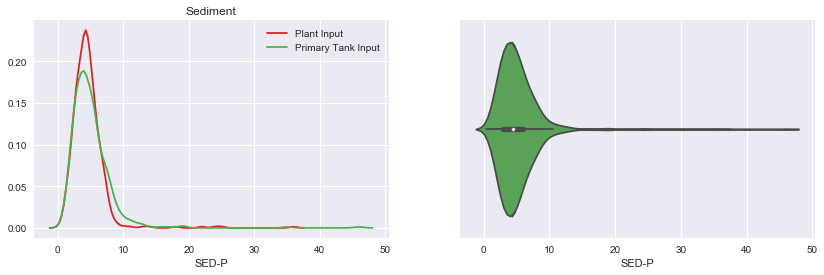

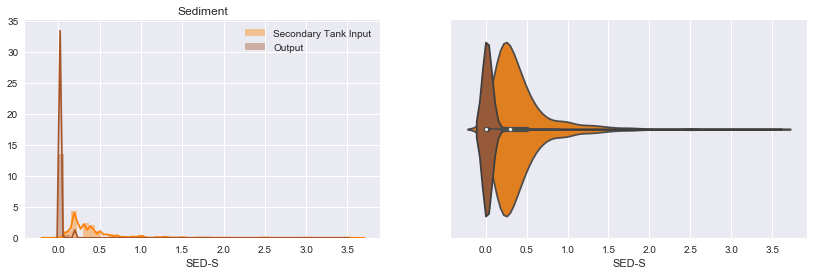

In [44]:
label_prefixes = ['SED']
titles = ['Sediment']

label_suffixes = ['-E','-P']#,
label_suffixes2 = ['-D','-S']
label_legend = ['Plant Input','Primary Tank Input']#,
label_legend2 = ['Secondary Tank Input','Output']

# color by label suffix (plant input, primary input, secondary input)
def get_cmap(n):
    #colorz = plt.cm.cool
    colorz = plt.get_cmap('Set1')
    return [ colorz(float(i)/n) for i in range(n)]
colorz = get_cmap(len(label_suffixes)+len(label_suffixes2))


for i,label_prefix in enumerate(label_prefixes):
    
    fig = figure(figsize=(14,4))
    ax1,ax2 = [fig.add_subplot(121+j) for j in range(2)]

    for j,label_suffix in enumerate(label_suffixes):
        
        this_label = label_prefix + label_suffix
        xx = df[this_label].dropna()

        sns.distplot(xx, label=label_legend[j], 
                     color=colorz[j],
                     kde=True, hist=False,
                     ax=ax1)

        sns.violinplot(xx, label=label_legend[j],
              color=colorz[j],
              alpha=0.4,
              ax=ax2)
        
        ax1.set_title(titles[i])
        ax1.legend(loc='upper right')

    
    fig = figure(figsize=(14,4))
    ax1,ax2 = [fig.add_subplot(121+j) for j in range(2)]
    
    for j,label_suffix in enumerate(label_suffixes2):

        this_label = label_prefix + label_suffix
        xx = df[this_label].dropna()

        sns.distplot(xx, label=label_legend2[j], 
                     color=colorz[len(label_suffixes)+j],
                     kde=True, hist=True, 
                     kde_kws={'kernel':'tri'},
                     ax=ax1)
        
        sns.violinplot(xx, label=label_legend[j],
              color=colorz[len(label_suffixes)+j],
              alpha=0.4,
              ax=ax2)
        
        ax1.set_title(titles[i])
        ax1.legend(loc='upper right')
    
plt.show()

## Performance Inputs and Global Performance Inputs

There are two additional sets of input variables we haven't examined yet, so-called "performance inputs" and "global performance inputs". 

```
29  RD-DBO-P  (performance input Biological demand of oxygen...
30   RD-SS-P  (performance input suspended solids to primary...
31  RD-SED-P   (performance input sediments to primary settler)
32  RD-DBO-S  (performance input Biological demand of oxygen...
33  RD-DQO-S  (performance input chemical demand of oxygen t...
34  RD-DBO-G  (global performance input Biological demand of...
35  RD-DQO-G  (global performance input chemical demand of o...
36   RD-SS-G        (global performance input suspended solids)
37  RD-SED-G               (global performance input sediments)
```

In [26]:
pprint([(i,j) for i,j in zip(info['Code'][-9:],info['Description'][-9:])])

[('RD-DBO-P',
  '(performance input Biological demand of oxygen in primary settler)'),
 ('RD-SS-P', '(performance input suspended solids to primary settler)'),
 ('RD-SED-P', '(performance input sediments to primary settler)'),
 ('RD-DBO-S',
  '(performance input Biological demand of oxygen to secondary settler)'),
 ('RD-DQO-S',
  '(performance input chemical demand of oxygen to secondary settler)'),
 ('RD-DBO-G', '(global performance input Biological demand of oxygen)'),
 ('RD-DQO-G', '(global performance input chemical demand of oxygen)'),
 ('RD-SS-G', '(global performance input suspended solids)'),
 ('RD-SED-G', '(global performance input sediments)')]


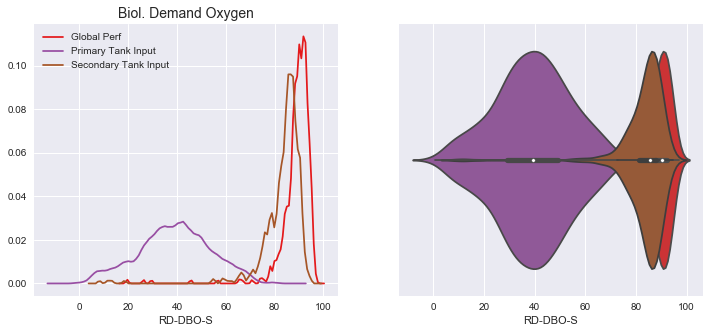

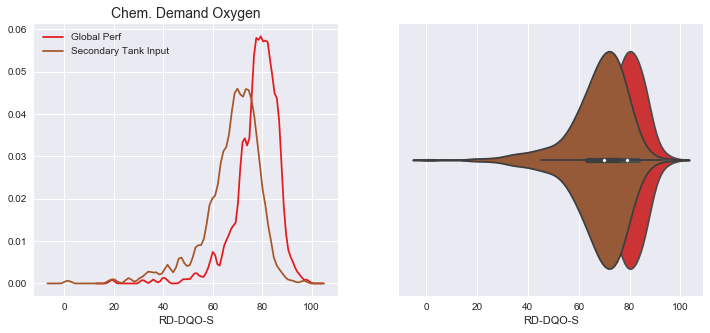

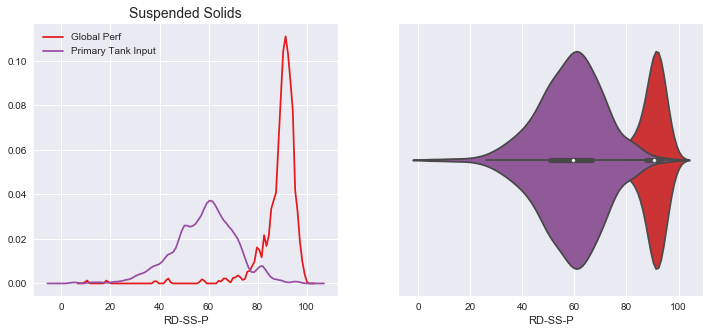

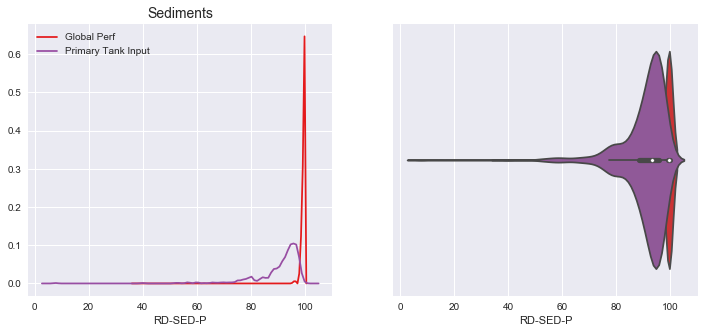

In [27]:
label_prefixes = ['RD-DBO','RD-DQO','RD-SS','RD-SED']
titles = ['Biol. Demand Oxygen','Chem. Demand Oxygen','Suspended Solids','Sediments']

label_suffixes = ['-G','-P','-S'] # note, -S refers to output, not secondary, in the above labels. very confusing.
label_legend = ['Global Perf','Primary Tank Input','Secondary Tank Input']

# color by label suffix (plant input, primary input, secondary input)
def get_cmap(n):
    colorz = plt.get_cmap('Set1')
    return [ colorz(float(i)/n) for i in range(n)]
colorz = get_cmap(len(label_suffixes))

for i,label_prefix in enumerate(label_prefixes):

    fig = figure(figsize=(12,5))
    ax1, ax2 = [fig.add_subplot(121+k) for k in range(2)]

    for j,label_suffix in enumerate(label_suffixes):
    
        this_label = label_prefix + label_suffix
        
        try:
            xx = df[this_label].dropna()

            sns.distplot(xx, label=label_legend[j], 
                         color=colorz[j],
                         kde=True, hist=False,
                         kde_kws={'kernel':'tri'},
                         ax=ax1)
            
            sns.violinplot(xx, label=label_legend[j],
                          color=colorz[j],
                          alpha=0.4,
                          ax=ax2)
            
        except KeyError:
            pass
            
    ax1.set_title(titles[i], fontsize=14)
    ax1.legend(loc='upper left')
    
    
plt.show()

# Normalize Data

Next, we'll normalize the data and compute the covariance between the different variables to see how they vary toegether. We can then do an eigenvalue analysis of the covariance matrix to see if there is a reduced variable space that would be useful to look at.

We'll start by scaling all of the observed data together, then we'll split each measurement into groups (input to plant, primary tank input, secondary tank input, output, etc.)

In [28]:
def get_normed_mean_cov(X):
    X_std = StandardScaler().fit_transform(X)
    X_mean = np.mean(X_std, axis=0)
    
    ## Automatic:
    #X_cov = np.cov(X_std.T)
    
    # Manual:
    X_cov = (X_std - X_mean).T.dot((X_std - X_mean)) / (X_std.shape[0]-1)
    
    return X_std, X_mean, X_cov

print("")

In [29]:
#inputs
#plant_inputs
#tank1_inputs
#tank2_inputs
#perf_inputs
#glob_inputs
#outputs

X_inputs = df[ inputs['Code'].values ].values
X_plant_inputs = df[ plant_inputs['Code'].values ].values
X_tank1_inputs = df[ tank1_inputs['Code'].values ].values
X_tank2_inputs = df[ tank2_inputs['Code'].values ].values

In [30]:
X_inputs

array([[  4.41010000e+04,   1.50000000e+00,   7.80000000e+00, ...,
          7.23000000e+01,   3.00000000e-01,   2.01000000e+03],
       [  3.90240000e+04,   3.00000000e+00,   7.70000000e+00, ...,
          7.92000000e+01,   4.00000000e-01,   2.70000000e+03],
       [  3.22290000e+04,   5.00000000e+00,   7.60000000e+00, ...,
          7.83000000e+01,   2.00000000e-01,   1.74200000e+03],
       ..., 
       [  3.29220000e+04,   3.00000000e-01,   7.40000000e+00, ...,
          8.57000000e+01,   1.00000000e-01,   1.15200000e+03],
       [  3.21900000e+04,   3.00000000e-01,   7.30000000e+00, ...,
          7.66000000e+01,   1.00000000e-01,   1.35100000e+03],
       [  3.04880000e+04,   2.10000000e-01,   7.50000000e+00, ...,
          8.44000000e+01,              nan,   1.18800000e+03]])

## Plant Input Covariance Heatmaps: All Inputs


In [31]:
def get_normed_mean_cov(X):
    X_std = StandardScaler().fit_transform(X)
    X_mean = np.mean(X_std, axis=0)
    
    ## Automatic:
    #X_cov = np.cov(X_std.T)
    
    # Manual:
    X_cov = (X_std - X_mean).T.dot((X_std - X_mean)) / (X_std.shape[0]-1)
    
    return X_std, X_mean, X_cov


X_inputs = df[ inputs['Code'].values ]
X_inputs = X_inputs.dropna()
X_inputs = X_inputs.values

X_std, X_mean, X_cov = get_normed_mean_cov(X_inputs)

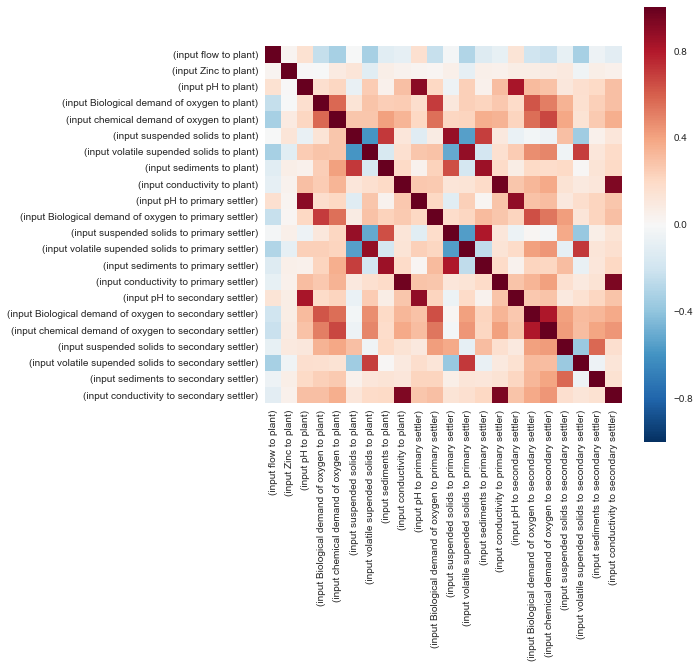

In [32]:
fig = figure(figsize=(8,8))
sns.heatmap(X_cov, 
            square=True,
            xticklabels=inputs['Description'].values,
            yticklabels=inputs['Description'].values
           )
plt.show()

## Plant Input Covariance Heatmaps: By Category

The following heatmaps show covariance of inputs, split up by category: plant inputs, primary settling tank inputs, and secondary settling tank inputs.

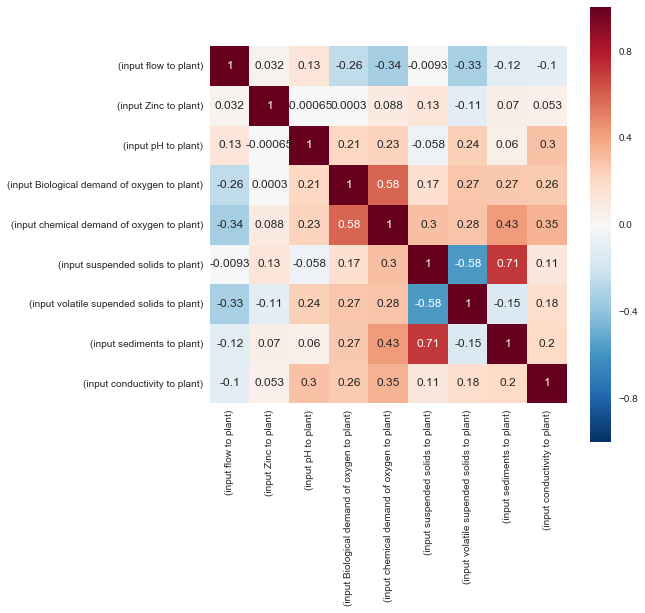

In [33]:
X_inputs = df[ plant_inputs['Code'].values ]
X_inputs = X_inputs.dropna()
X_inputs = X_inputs.values

X_std, X_mean, X_cov = get_normed_mean_cov(X_inputs)

fig = figure(figsize=(8,8))
sns.heatmap(X_cov, 
            square=True,
            xticklabels=plant_inputs['Description'].values,
            yticklabels=plant_inputs['Description'].values,
            annot=True
           )
plt.show()

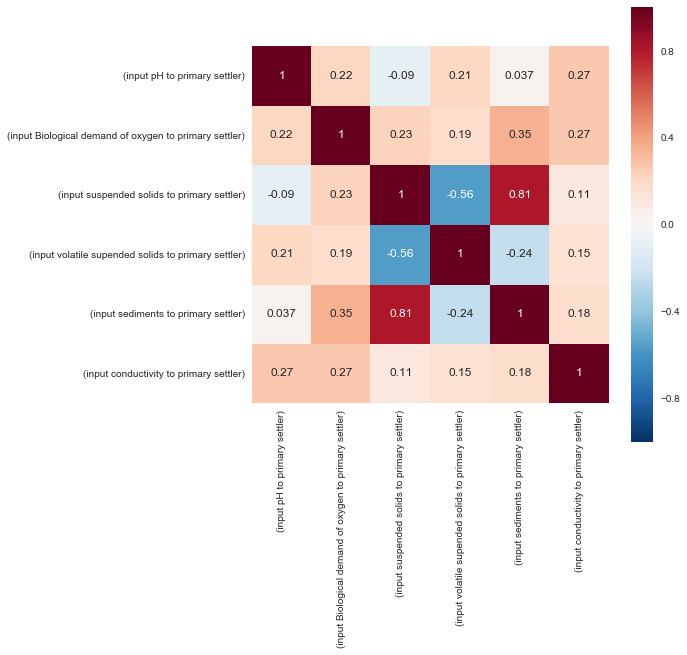

In [34]:
X_inputs = df[ tank1_inputs['Code'].values ]
X_inputs = X_inputs.dropna()
X_inputs = X_inputs.values

X_std, X_mean, X_cov = get_normed_mean_cov(X_inputs)

fig = figure(figsize=(8,8))
sns.heatmap(X_cov, 
            square=True,
            xticklabels=tank1_inputs['Description'].values,
            yticklabels=tank1_inputs['Description'].values,
            annot=True
           )
plt.show()

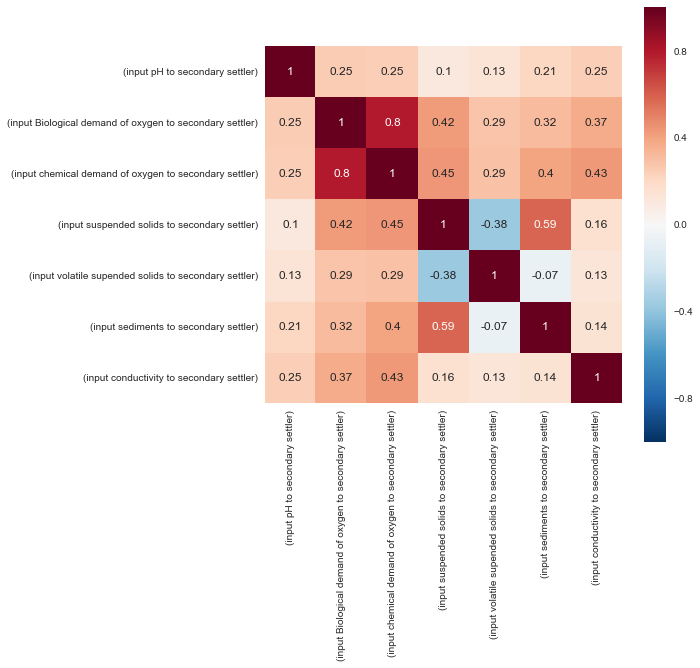

In [35]:
X_inputs = df[ tank2_inputs['Code'].values ]
X_inputs = X_inputs.dropna()
X_inputs = X_inputs.values

X_std, X_mean, X_cov = get_normed_mean_cov(X_inputs)

fig = figure(figsize=(8,8))
sns.heatmap(X_cov, 
            square=True,
            xticklabels=tank2_inputs['Description'].values,
            yticklabels=tank2_inputs['Description'].values,
            annot=True
           )
plt.show()

## Plant Input Covariance Eigenvalue/Eigenvector Analysis

Next up we will compute the eigenvectors and eigenvalues of the covariance matrix, to see if we find anything interesting - perhaps a single principal component that explains away all of the variance? (No such luck here.)

In [36]:
X_inputs = df[ inputs['Code'].values ]
X_inputs = X_inputs.dropna()
X_inputs = X_inputs.values

X_std, X_mean, X_cov = get_normed_mean_cov(X_inputs)
eigenvals, eigenvecs = np.linalg.eig(X_cov)
unsrt_eigenvalvec = [(np.abs(eigenvals[i]), eigenvecs[:,i]) for i in range(len(eigenvals))]
eigenvalvec = sorted(unsrt_eigenvalvec, reverse=True, key=lambda x:x[0])

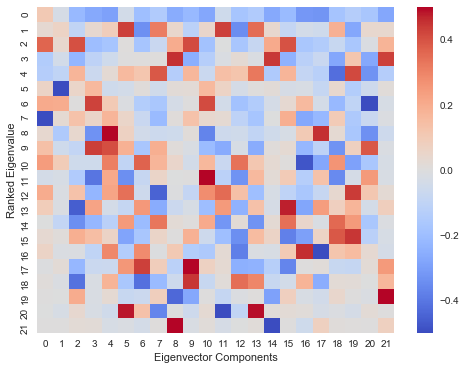

In [37]:
fig = plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame([pair[1] for pair in eigenvalvec]), 
            annot=False, cmap='coolwarm',
           vmin=-0.5,vmax=0.5)

plt.ylabel("Ranked Eigenvalue")
plt.xlabel("Eigenvector Components")
plt.show()

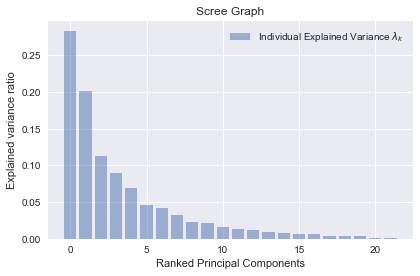

In [38]:
lam_sum = sum(eigenvals)
explained_variance = [(lam_k/lam_sum) for lam_k in sorted(eigenvals, reverse=True)]

plt.figure(figsize=(6, 4))

plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center',
        label='Individual Explained Variance $\lambda_{k}$')

plt.ylabel('Explained variance ratio')
plt.xlabel('Ranked Principal Components')
plt.title("Scree Graph")

plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Next Steps

Working toward outlier detection, but next steps will require slimming down what we're looking at, and that will require a better understanding of it.